# Neural Network Quantile Regressor

Tutorial to generate probabilistic predictions with Keras Neural Network.

Do not forget to install package with: <b>pip3 install tensorflow</b>

### Load example dataset

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from modules import *

In [2]:
dataset_size = 700
Time = np.arange(dataset_size)
# add 5 to avoid negative values (we use rectified linear unit as activation)
Prevision = np.sin(Time/4)
Measure = np.sin(Time/4) + np.random.normal(loc=.1, scale=0.2, size=dataset_size)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(np.concatenate((Time.reshape(-1,1), Prevision.reshape(-1,1)), axis=1), Measure, test_size=0.2, shuffle=False)

## Create Neural Network model

In [4]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

from functools import partial, update_wrapper
# partial function that keep the same name
def wrapped_partial(func, name=None, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    if name is not None:
        partial_func.__name__ = name
    return partial_func

In [5]:
# create a simple sequential MLP
activation = keras.layers.LeakyReLU(alpha=0.3)
def mlp(input_shape, output_size):
    model = Sequential()
    model.add(Dense(50, input_dim=input_shape, activation=activation))
    model.add(Dense(20, activation=activation))
    model.add(Dense(output_size, activation=activation))
    return model

In [6]:
# soft parameter
a = 0.005

# select quantiles when you predict
quantiles = np.array([0.05,0.25,0.5,0.75,0.95])
nb_q = len(quantiles)

# Pinball loss (used as metric)
def pinball(y_true, y_pred, alpha):
    x = y_pred - y_true
    return -x*alpha*(K.cast(K.less(x,0.0), "float32")) + (1.0-alpha)*x*(K.cast(K.less(0.0,x), "float32"))

# Chen Mangasarian C2 approximation of Pinball Loss
def chen_mangasarian(y_true, y_pred, alpha=0.9, a=0.1):
    x = K.cast(y_pred - y_true, "float64")
    root = K.cast(a * (K.log(1-alpha) - K.log(alpha)), "float64")
    x = x - root
    return (1-alpha)*x + a*K.log(1+ K.exp(-x/a))

chen_manga_loss = wrapped_partial(chen_mangasarian, alpha=quantiles, a=a, name="chen_manga_loss")
pinball_metric = wrapped_partial(pinball, name='pinball_metric', alpha=quantiles)

In [7]:
# callbacks
es = EarlyStopping(monitor="val_pinball_metric", mode='min', patience=10, verbose=1)

# learning rate
lr = 1e-4

# optimizer
opt = keras.optimizers.Adam(lr=lr)

# create model
model = mlp(X_train.shape[1], len(quantiles))

# compile model
model.compile(loss=chen_manga_loss, metrics=[pinball_metric], optimizer=opt)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-10-29 16:50:49,740 - tensorflow - WARNING - From /home/gdemange/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
Total params: 1,275
Trainable params: 1,275
Non-trainable params: 0
_________________________________________________________________


In [9]:
result = model.fit(scale(X_train), 
                   y_train,
                   epochs=1500,
                   batch_size=32,
                   verbose=0,
                   callbacks=[es], 
                   validation_split=0.3)

Epoch 00272: early stopping


In [10]:
time_test_set = X_test[:,0]
prevision_test_set = X_test[:,1]
measure_test_set = y_test
quantiles_test_set = model.predict(scale(X_test))

### Plot Results

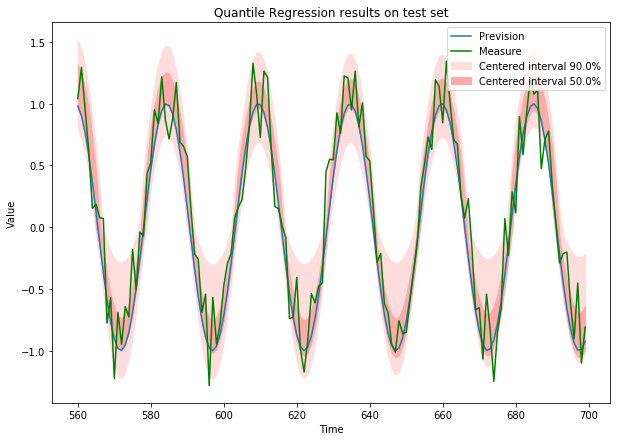

In [11]:
plt.subplots(figsize=(10,7))

# plot deterministic prevision/measure
plt.plot(time_test_set, prevision_test_set)
plt.plot(time_test_set, measure_test_set, "green")

lg = ["Prevision", "Measure"] 

# we plot quantiles as centered prediction intervals
colors = ["#FFDDDD", "#FFAAAA", "FF8888"]
for i in range(nb_q//2):
    plt.fill_between(time_test_set, quantiles_test_set[:,i], quantiles_test_set[:,nb_q-i-1], color=colors[i])
    lg.append(f"Centered interval {round((quantiles[nb_q-i-1] - quantiles[i])*100, 2)}%")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Quantile Regression results on test set")
plt.legend(lg)

### Metrics

Note on metrics: <b>python-perfcheck</b> package will contains probabilistic metrics, but it won't be possible to pass model as input. q_alpha will only be a quantile matrix or dataframe.

<b>Continuous Ranked Probability Score</b> (global performance metric, sharpness metric, sharpness variance which is roughly a resolution metric)

In [12]:
crps, crps_list, sharpness, sharpness_list, resolution = mean_crps(model, 
                                                                   quantiles, 
                                                                   scale(X_test), 
                                                                   y_test, 
                                                                   bounds=[-2,2], 
                                                                   sharpness=True, 
                                                                   resolution=True)
crps, sharpness, resolution

/home/gdemange/probabilistic-predictions/modules/metrics.py:376: UserWarning: Quantiles are crossing each others for at least [0.31304955 0.29780924 0.5006834  0.6779464  0.8445436 ], compute score with sorted quantiles values
  warnings.warn(f"Quantiles are crossing each others for at least {q_alpha[i]}, compute score with sorted quantiles values")


(0.11986634216917759, 0.04888774332712638, 0.007965631184557061)

<b>Probability Integral Transform</b> (PIT, reliability metric)

/home/gdemange/probabilistic-predictions/modules/metrics.py:376: UserWarning: Quantiles are crossing each others for at least [0.31304955 0.29780924 0.5006834  0.6779464  0.8445436 ], compute score with sorted quantiles values
  warnings.warn(f"Quantiles are crossing each others for at least {q_alpha[i]}, compute score with sorted quantiles values")


Text(0, 0.5, 'Ratio below the quantile')

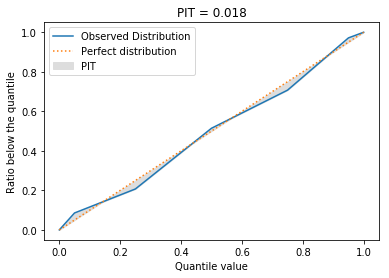

In [13]:
quantiles_distribution = fiability(model.predict(scale(X_test)), quantiles, None, y_test, bounds=[-2,2])
import matplotlib.pyplot as plt
qt_theo_prob_bounded = np.concatenate(([0], quantiles_distribution[:,0], [1]))
qt_real_prob_bounded = np.concatenate(([0], quantiles_distribution[:,1], [1]))
plt.plot(qt_theo_prob_bounded, qt_real_prob_bounded)
plt.title(f"PIT = {np.round(pit(quantiles_distribution), 3)}")
plt.plot([0,1],[0,1], linestyle='dotted')
plt.fill_between(qt_theo_prob_bounded, qt_theo_prob_bounded, qt_real_prob_bounded, color="#DDDDDD")
plt.legend(["Observed Distribution", "Perfect distribution", "PIT"])
plt.xlabel("Quantile value")
plt.ylabel("Ratio below the quantile")

<b>CRPS Decomposition</b> (from CRPS decomposition)

In [14]:
crps_rel = rel(model, quantiles, scale(X_test), y_test, bounds=[-2,2])
crps_rel

/home/gdemange/probabilistic-predictions/modules/metrics.py:376: UserWarning: Quantiles are crossing each others for at least [0.31304955 0.29780924 0.5006834  0.6779464  0.8445436 ], compute score with sorted quantiles values
  warnings.warn(f"Quantiles are crossing each others for at least {q_alpha[i]}, compute score with sorted quantiles values")


0.0016077842640542389

In [15]:
crps_resolution = res(model, quantiles, scale(X_test), y_test, bounds=[-2,2])
crps_resolution

/home/gdemange/probabilistic-predictions/modules/metrics.py:376: UserWarning: Quantiles are crossing each others for at least [0.31304955 0.29780924 0.5006834  0.6779464  0.8445436 ], compute score with sorted quantiles values
  warnings.warn(f"Quantiles are crossing each others for at least {q_alpha[i]}, compute score with sorted quantiles values")


0.29696406599339076

In [16]:
uncertainty = unc(y_test)
uncertainty

0.42207268423879873

In [17]:
pot = np.sum(crps_pot(model, quantiles, scale(X_test), y_test, bounds=[-2,2])[0])
pot

/home/gdemange/probabilistic-predictions/modules/metrics.py:376: UserWarning: Quantiles are crossing each others for at least [0.31304955 0.29780924 0.5006834  0.6779464  0.8445436 ], compute score with sorted quantiles values
  warnings.warn(f"Quantiles are crossing each others for at least {q_alpha[i]}, compute score with sorted quantiles values")


0.12510861824540798

In [18]:
brier = crps_brier(model, quantiles, scale(X_test), y_test, bounds=[-2,2])

/home/gdemange/probabilistic-predictions/modules/metrics.py:376: UserWarning: Quantiles are crossing each others for at least [0.31304955 0.29780924 0.5006834  0.6779464  0.8445436 ], compute score with sorted quantiles values
  warnings.warn(f"Quantiles are crossing each others for at least {q_alpha[i]}, compute score with sorted quantiles values")


In [19]:
brier, pot + crps_rel, uncertainty - crps_resolution + crps_rel

(0.12671640250946234, 0.12671640250946223, 0.12671640250946223)

Brier CRPS = Potential CRPS + Reliability = Uncertainty - Resolution + Reliability

$\textbf{Remark:}$ You can also compute Pinball Score. I do not use it as a metric during my project, but it can be a pretty good global metric.